# Santander Classification Problem

# Getting Started

> I am going to begin my first loading the training dataset and observing the first 5-10 rows of the datset. This will give me a clear picture as to what kind of data I am looking at.

In [9]:
import numpy as np
import pandas as pd

from IPython.display import display
%matplotlib inline

# Load the dataset
in_file = 'train.csv'
full_data = pd.read_csv(in_file)

# Print the first few entries of the RMS Titanic data
print display(full_data.head())

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,39205.170000,0
1,3,2,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,49278.030000,0
2,4,2,23,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,67333.770000,0
3,8,2,37,0,195,195,0,0,0,0,...,0,0,0,0,0,0,0,0,64007.970000,0
4,10,2,39,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,117310.979016,0


None


In [10]:
# Store the 'Survived' feature in a new variable and remove it from the dataset
outcomes = full_data['TARGET']
data = full_data.drop('TARGET', axis = 1)

# Show the new dataset with 'Survived' removed
display(data.head())

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,1,2,23,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,39205.170000
1,3,2,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49278.030000
2,4,2,23,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,67333.770000
3,8,2,37,0,195,195,0,0,0,0,...,0,0,0,0,0,0,0,0,0,64007.970000
4,10,2,39,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,117310.979016


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import csv
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lasagne import layers as lasagne, nonlinearities as nl
from sknn.mlp import Classifier, Layer
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation

columnNamesToTry = ['saldo_var30', 'var15', 'saldo_medio_var5_hace2', 'saldo_var42',
'saldo_medio_var5_ult1', 'saldo_medio_var5_ult3', 'saldo_var5', 'num_meses_var5_ult3', 'saldo_medio_var5_hace3']

def cleanUpScript():
    global data
    colsToRemove = []
    for col in data.columns:
        if data[col].std() == 0:
            colsToRemove.append(col)
    data.drop(colsToRemove, axis=1, inplace=True)

def removeDuplicateColumns():
    global data
    colsToRemove = []
    columns = data.columns
    for i in range(len(columns)-1):
        v = data[columns[i]].values
        for j in range(i+1,len(columns)):
            if np.array_equal(v,data[columns[j]].values):
                colsToRemove.append(columns[j])
    data.drop(colsToRemove, axis=1, inplace=True)

cleanUpScript()
removeDuplicateColumns()

cleaned_data = data[[col for col in data.columns if col in columnNamesToTry]]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    cleaned_data, outcomes, test_size=0.4, random_state=0)

model = None
y_out = None

def testGradientBoostingClassifier():
    return GradientBoostingClassifier(learning_rate = 1.0, n_estimators = 300)
    
def testModel(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print metrics.accuracy_score(y_test, y_pred)
    
model = testGradientBoostingClassifier()
testModel(model)


def actualTest():
    in_file = 'test.csv'
    testing_data = pd.read_csv(in_file)
    subset_testing_data = testing_data[[col for col in testing_data.columns if col in columnNamesToTry]]
    testing_labels = model.predict(subset_testing_data)

def outputSubmissionFile():
    with open("submission.csv","w") as datafile:
        writer = csv.writer(datafile)

        output = []
        output.append(["ID","TARGET"])

        for i in range(len(testing_labels)):
            output.append([int(testing_data.iloc[i][0]), testing_labels[i]])
        writer.writerows(output)

0.949782951855


In [22]:
print subset_testing_data.iloc[15411][:]

var15                      43.00
ind_var5                    1.00
ind_var30                   1.00
num_var4                    2.00
num_var5                    3.00
num_var30                   3.00
num_var35                   6.00
num_var42                   0.00
saldo_var5               -876.30
saldo_var30              -876.30
saldo_var42              -876.30
num_meses_var5_ult3         3.00
saldo_medio_var5_hace2   -385.47
saldo_medio_var5_hace3      0.18
saldo_medio_var5_ult1    -876.03
saldo_medio_var5_ult3    -420.45
Name: 15411, dtype: float64


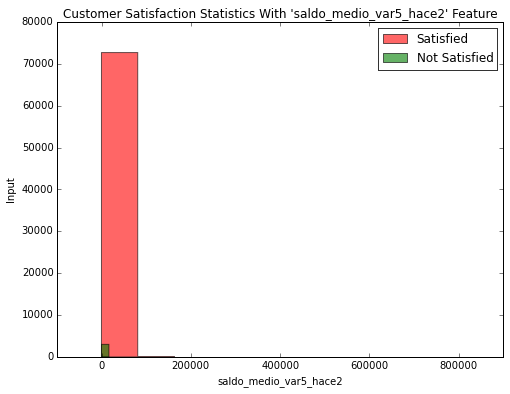

In [37]:
from santander_visualizations import satisfaction_stats

satisfaction_stats(data, outcomes, 'saldo_medio_var5_hace2')